## Proyecto de minería de datos 2019-1: fase 3 - Clasificación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('matched.csv')
quakedf = data.copy()
display(quakedf.describe())
display(quakedf.head())
display(quakedf.info())

,LATITUDE,LONGITUDE,DEPTH,GAP,MAGNITUDE,DMIN,RMS,TSUNAMI
count,408.000000,408.000000,408.000000,154.000000,408.000000,58.000000,261.000000,408.0
mean,14.895339,65.319253,28.186696,26.235714,7.302647,2.037609,1.052797,1.0
std,28.109836,117.906955,33.300888,25.412571,0.644700,1.709464,0.199927,0.0
min,-60.273800,-179.971000,0.000000,9.000000,5.000000,0.008108,0.070000,1.0
25%,-9.526250,-70.521825,15.000000,15.000000,6.900000,0.733000,0.930000,1.0
50%,17.930500,135.362000,24.000000,20.750000,7.300000,1.516500,1.070000,1.0
75%,39.418750,147.691000,33.000000,29.000000,7.800000,2.575750,1.200000,1.0
max,59.820900,179.146100,600.000000,271.000000,9.500000,8.050000,1.510000,1.0


,DATE,LATITUDE,LONGITUDE,DEPTH,GAP,MAGNITUDE,MAGTYPE,DMIN,RMS,PLACE,TSUNAMI
0,1901-08-09 18:33:00.000,40.000,144.000,0.0,NaN,7.5,mw,NaN,NaN,"off the east coast of Honshu, Japan",1
1,1905-09-08 01:43:02.000,38.636,15.784,15.0,NaN,7.2,mw,NaN,NaN,"Sicily, Italy",1
2,1906-01-31 15:36:10.000,0.955,-79.369,20.0,NaN,8.8,mw,NaN,NaN,1906 Ecuador-Colombia Earthquake,1
3,1906-09-14 16:04:43.000,-6.249,147.281,35.0,NaN,8.0,mw,NaN,NaN,"eastern New Guinea region, Papua New Guinea",1
4,1907-01-04 05:19:11.000,1.873,94.209,15.0,NaN,7.8,mw,NaN,NaN,off the west coast of northern Sumatra,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 11 columns):
DATE         408 non-null object
LATITUDE     408 non-null float64
LONGITUDE    408 non-null float64
DEPTH        408 non-null float64
GAP          154 non-null float64
MAGNITUDE    408 non-null float64
MAGTYPE      408 non-null object
DMIN         58 non-null float64
RMS          261 non-null float64
PLACE        408 non-null object
TSUNAMI      408 non-null int64
dtypes: float64(7), int64(1), object(3)
memory usage: 35.2+ KB


None

Datos nulos en %

In [3]:
quakedf.isna().sum()/len(quakedf)*100

DATE          0.000000
LATITUDE      0.000000
LONGITUDE     0.000000
DEPTH         0.000000
GAP          62.254902
MAGNITUDE     0.000000
MAGTYPE       0.000000
DMIN         85.784314
RMS          36.029412
PLACE         0.000000
TSUNAMI       0.000000
dtype: float64

Se descartan GAP y DMIN debido a la cantidad de % de nulos, además de RMS, ya que no tiene sentido imputarlo.

In [4]:
quakedf = quakedf.drop(columns=['GAP','DMIN','RMS'])

Dado que el análisis no considerará tiempo ni posición por simplicidad, se descartan DATE, LATITUDE, LONGITUDE, PLACE.

In [5]:
quakedf = quakedf.drop(columns=['DATE','LATITUDE','LONGITUDE','PLACE'])

Mismo tratamiento para dataset con terremotos que no generan tsunamis.

In [45]:
chiledf = pd.read_csv('data/chile.csv')
chiledf['TSUNAMI'] = 0
earthquakes = chiledf[['depth','mag','magType','TSUNAMI']].copy()
earthquakes.rename(columns={'depth':'DEPTH', 'mag':'MAGNITUDE', 'magType':'MAGTYPE'}, inplace=True)
earthquakes.head()
earthquakes['MAGTYPE'].value_counts()

mb       2805
mwr      1039
mww       301
ml        157
md         15
mb_lg       1
Name: MAGTYPE, dtype: int64

In [25]:
quakedf['MAGTYPE'].value_counts()

mw     180
mww     85
mwc     81
ms      36
mwb     23
mh       2
mb       1
Name: MAGTYPE, dtype: int64

Se realiza el análisis solo para magnitud tipo mww, debido a la poca ocurrencia del resto en ambas tablas.

In [57]:
quakemww = pd.concat([quakedf[quakedf['MAGTYPE']=='mww'], earthquakes[earthquakes['MAGTYPE']=='mww']],axis=0)
quakemww = quakemww.sample(frac=1).reset_index(drop=True)
quakemww = quakemww.drop(columns=['MAGTYPE'])

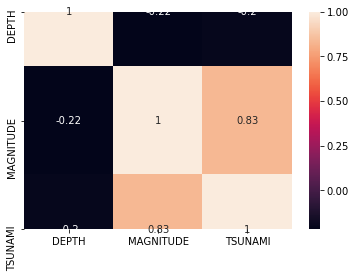

In [103]:
corrmatrix=quakemww.corr()
sns.heatmap(corrmatrix, robust=True, annot=True)

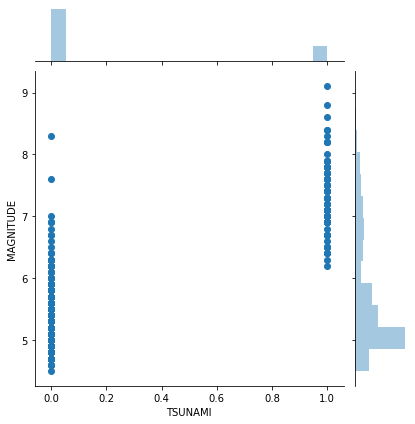

In [107]:
sns.jointplot(x = 'TSUNAMI', y = 'MAGNITUDE', data = quakemww);

/home/fabricio/anaconda3/envs/comcat/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/fabricio/anaconda3/envs/comcat/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


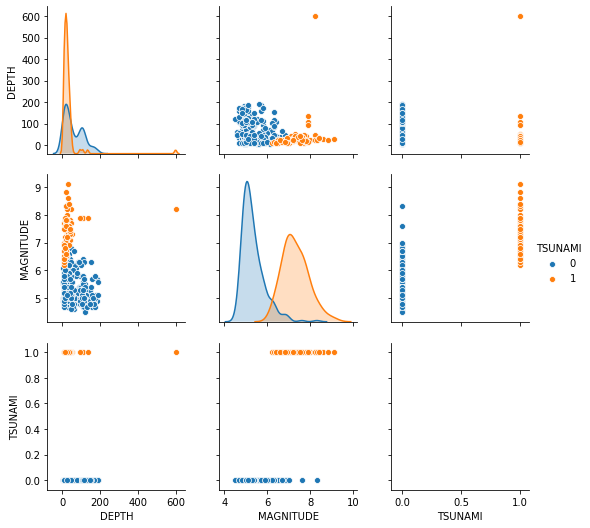

In [73]:
sns.pairplot(quakemww, hue='TSUNAMI')

Se prueba utilizando diferentes clasificadores

In [69]:
from sklearn import metrics
from datetime import datetime

def ROC_and_metrics(name, clf):
    fig, ax = plt.subplots()
    tstart = datetime.now()
    clf.fit(X_train, y_train)
    tend = datetime.now()
    tend_fit = tend - tstart
    ax.set_title(name)

    # compute ROC curve
    tstart = datetime.now()
    y_test_pred = clf.predict_proba(X_test)[:, 1]
    tend = datetime.now()
    tend_pred = tend - tstart
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred, pos_label=1)
    auc = metrics.roc_auc_score(y_test, y_test_pred)
    acc = metrics.accuracy_score(y_test, y_test_pred >= 0.5)
    f1 = metrics.f1_score(y_test, y_test_pred >= 0.5)
    ax.text(0.95, 0.3, "Acc: %.2f" % acc, ha = 'right')
    ax.text(0.95, 0.2, "F1-score: %.2f" % f1, ha = 'right')
    ax.text(0.95, 0.1, "AUC: %.2f" % auc, ha = 'right')
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.plot(fpr, tpr, lw = 1)
    idx = np.argmin(np.abs(thresholds - 0.5))
    ax.scatter(fpr[idx], tpr[idx], marker = 'o', c = 'r')
    return [tend_fit, tend_pred, acc, f1, auc]

/home/fabricio/anaconda3/envs/comcat/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


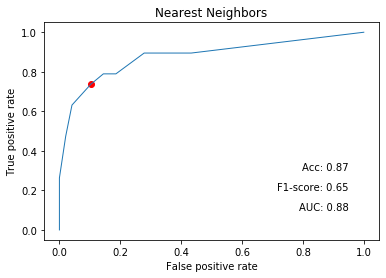

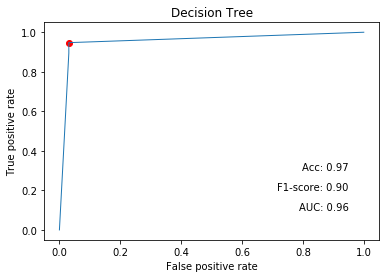

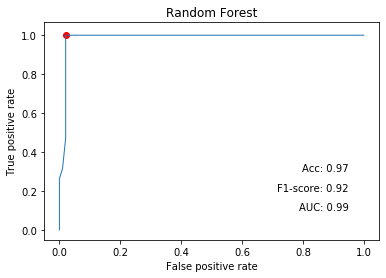

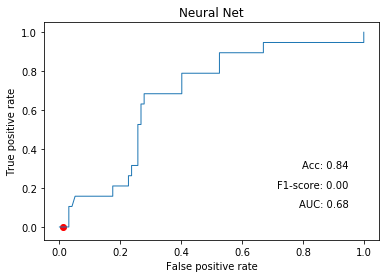

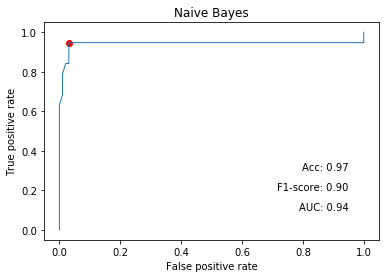

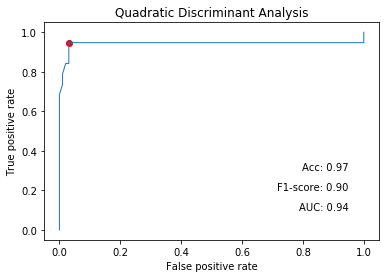

In [76]:
from sklearn.model_selection import train_test_split

# multilayer perceptron classifier
from sklearn.neural_network import MLPClassifier

# K nearest neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

# Decision tree classifier ASD
from sklearn.tree import DecisionTreeClassifier

# Ensemble classifiers: Random forest
from sklearn.ensemble import RandomForestClassifier

# Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

# Quadratic Discriminant Analysis classifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "Neural Net",
         "Naive Bayes", "Quadratic Discriminant Analysis"]

classifiers = [
    KNeighborsClassifier(n_neighbors=10),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10),
    MLPClassifier(alpha=1),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
X = quakemww[['DEPTH','MAGNITUDE']].values
y = quakemww['TSUNAMI'].values
score_data = []
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

for name, clf in zip(names, classifiers):
    score_data.append(ROC_and_metrics(name, clf))

El mejor desempeño se logra utilizando RandomForest.

Se realiza GridSearch para estimar parámetros del randomforest

In [92]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 42)
RandomForestClassifier(max_depth=10, n_estimators=10)
parameters = {'max_depth': range(1,16),'n_estimators':range(1,16)}
grid_RF = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
grid_RF.fit(X_train, y_train)
grid_results = pd.DataFrame(grid_RF.cv_results_)

/home/fabricio/anaconda3/envs/comcat/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [108]:
grid_RF

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

Resultado final

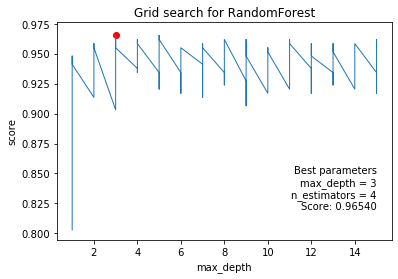

In [97]:
fig, ax = plt.subplots()
idx = np.argmax(grid_results.iloc[:,-3])
ax.set_title("Grid search for RandomForest")
ax.text(15, 0.850, "Best parameters", ha = 'right')
ax.text(15, 0.840, "max_depth = %i" % grid_RF.best_params_['max_depth'], ha = 'right')
ax.text(15, 0.830, "n_estimators = %i" % grid_RF.best_params_['n_estimators'], ha = 'right')
ax.text(15, 0.820, "Score: %.5f" % grid_results.iloc[idx,-3], ha = 'right')
ax.set_xlabel("max_depth")
ax.set_ylabel("score")
ax.plot(grid_results.iloc[:,4], grid_results.iloc[:,-3], lw = 1)
ax.scatter(grid_results.iloc[idx,4], grid_results.iloc[idx,-3], marker='o', c='r')